In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
n_samples = 1000


# Generate more influential base features
base_temp = np.random.uniform(15, 35, n_samples)
base_humidity = np.random.uniform(30, 80, n_samples)
base_pH = np.random.uniform(5.5, 7.5, n_samples)
nitrogen_level = np.random.uniform(3, 8, n_samples)

# Generate target soil moisture with stronger environmental dependencies
target_soil_moisture = (
    60 +
    (base_temp - 25) * 1.2 +  # Stronger temperature influence
    (base_humidity - 50) * 0.8 +  # Stronger humidity influence
    (base_pH - 6.5) * 5 +  # Stronger pH influence
    (nitrogen_level - 5.5) * 3 +  # Stronger nitrogen influence
    np.random.normal(0, 2, n_samples)
)
target_soil_moisture = np.clip(target_soil_moisture, 40, 80)

# Generate current soil moisture with stronger correlations
current_soil_moisture = (
    target_soil_moisture +
    (25 - base_temp) * 1.5 +  # Stronger temperature effect
    (base_humidity - 50) * 0.7 +  # Stronger humidity effect
    (base_pH - 6.5) * 4 +  # Stronger pH effect
    (nitrogen_level - 5.5) * 2.5 +  # Stronger nitrogen effect
    np.random.normal(0, 3, n_samples)
)
current_soil_moisture = np.clip(current_soil_moisture, 10, 90)


In [3]:
# Create the dataset
data = {
    'current_soil_moisture': current_soil_moisture,
    'target_soil_moisture': target_soil_moisture,
    'soil_type': np.random.choice(['Clay', 'Loam', 'Sandy', 'Silt', 'Peat'], n_samples),
    'soil_depth_in_pot': np.random.uniform(10, 30, n_samples),
    'soil_compaction_level': np.random.randint(1, 6, n_samples),
    'soil_pH': base_pH,
    'nitrogen_level': nitrogen_level,
    'ambient_temperature': base_temp,
    'relative_humidity': base_humidity,
    'sunlight_exposure': np.random.uniform(0, 12, n_samples),
    'plant_size': np.random.choice(['Small', 'Medium', 'Large'], n_samples),
    'leaf_surface_area': np.random.uniform(50, 500, n_samples),
    'plant_type': np.random.choice(['Succulent', 'Tropical', 'Herb', 'Flowering'], n_samples),
    'number_of_leaves': np.random.randint(5, 50, n_samples),
    'time_since_last_watering': np.random.uniform(0, 168, n_samples),
    'time_of_day': np.random.randint(0, 24, n_samples),
    'season': np.random.choice(['Summer', 'Winter', 'Spring', 'Fall'], n_samples)
}

In [4]:
# Create DataFrame
df = pd.DataFrame(data)
df.head()

,current_soil_moisture,target_soil_moisture,soil_type,soil_depth_in_pot,soil_compaction_level,soil_pH,nitrogen_level,ambient_temperature,relative_humidity,sunlight_exposure,plant_size,leaf_surface_area,plant_type,number_of_leaves,time_since_last_watering,time_of_day,season
0,45.805565,51.259163,Loam,14.681156,4,6.023411,6.363515,22.490802,39.256646,7.611952,Small,277.803966,Succulent,8,70.194071,6,Winter
1,72.421516,79.039559,Loam,10.995620,3,5.993958,6.983407,34.014286,57.095047,9.819783,Medium,61.534512,Herb,34,27.855448,21,Spring
2,89.762657,80.000000,Silt,15.370002,1,7.312509,4.252339,29.639879,73.647292,7.690250,Small,466.136364,Tropical,23,25.869982,17,Winter
3,85.602074,75.937181,Sandy,23.084716,2,5.999092,6.124370,26.973170,66.611244,3.724777,Medium,433.326564,Flowering,27,118.853614,18,Summer
4,88.699966,65.884400,Clay,20.672339,5,6.043899,5.858730,18.120373,70.328057,7.873334,Large,285.916068,Herb,22,163.744878,19,Winter


In [5]:
# Modified water needed calculation with stronger environmental dependencies
def calculate_water_needed(row):
    # Base water need based on moisture difference
    moisture_diff = row['target_soil_moisture'] - row['current_soil_moisture']
    base_water = moisture_diff * 50  # Removed pot_volume dependency

    # Stronger environmental factor adjustments
    temp_factor = 1 + (row['ambient_temperature'] - 25) * 0.08  # Doubled effect
    humidity_factor = 1 - (row['relative_humidity'] - 50) * 0.02  # Doubled effect

    # Stronger soil chemistry adjustments
    pH_factor = 1 + abs(row['soil_pH'] - 6.5) * 0.2  # Doubled effect
    nitrogen_factor = 1 + (row['nitrogen_level'] - 5) * 0.1  # Doubled effect

    # Soil type adjustments
    soil_type_factor = {
        'Sandy': 1.3,
        'Loam': 1.0,
        'Clay': 0.7,
        'Silt': 0.9,
        'Peat': 1.1
    }[row['soil_type']]

    # Calculate final water quantity with stronger environmental influences
    water_needed = (base_water *
                   temp_factor ** 2 *
                   humidity_factor ** 2 *
                   pH_factor ** 2 *
                   nitrogen_factor ** 2 *
                   soil_type_factor)

    return max(0, water_needed)


In [6]:
# Calculate target variable
df['water_quantity_needed'] = df.apply(calculate_water_needed, axis=1)

# Train the model
X = df.drop('water_quantity_needed', axis=1)
y = df['water_quantity_needed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical columns
categorical_features = ['soil_type', 'plant_size', 'plant_type', 'season']
numerical_features = [col for col in X.columns if col not in categorical_features]

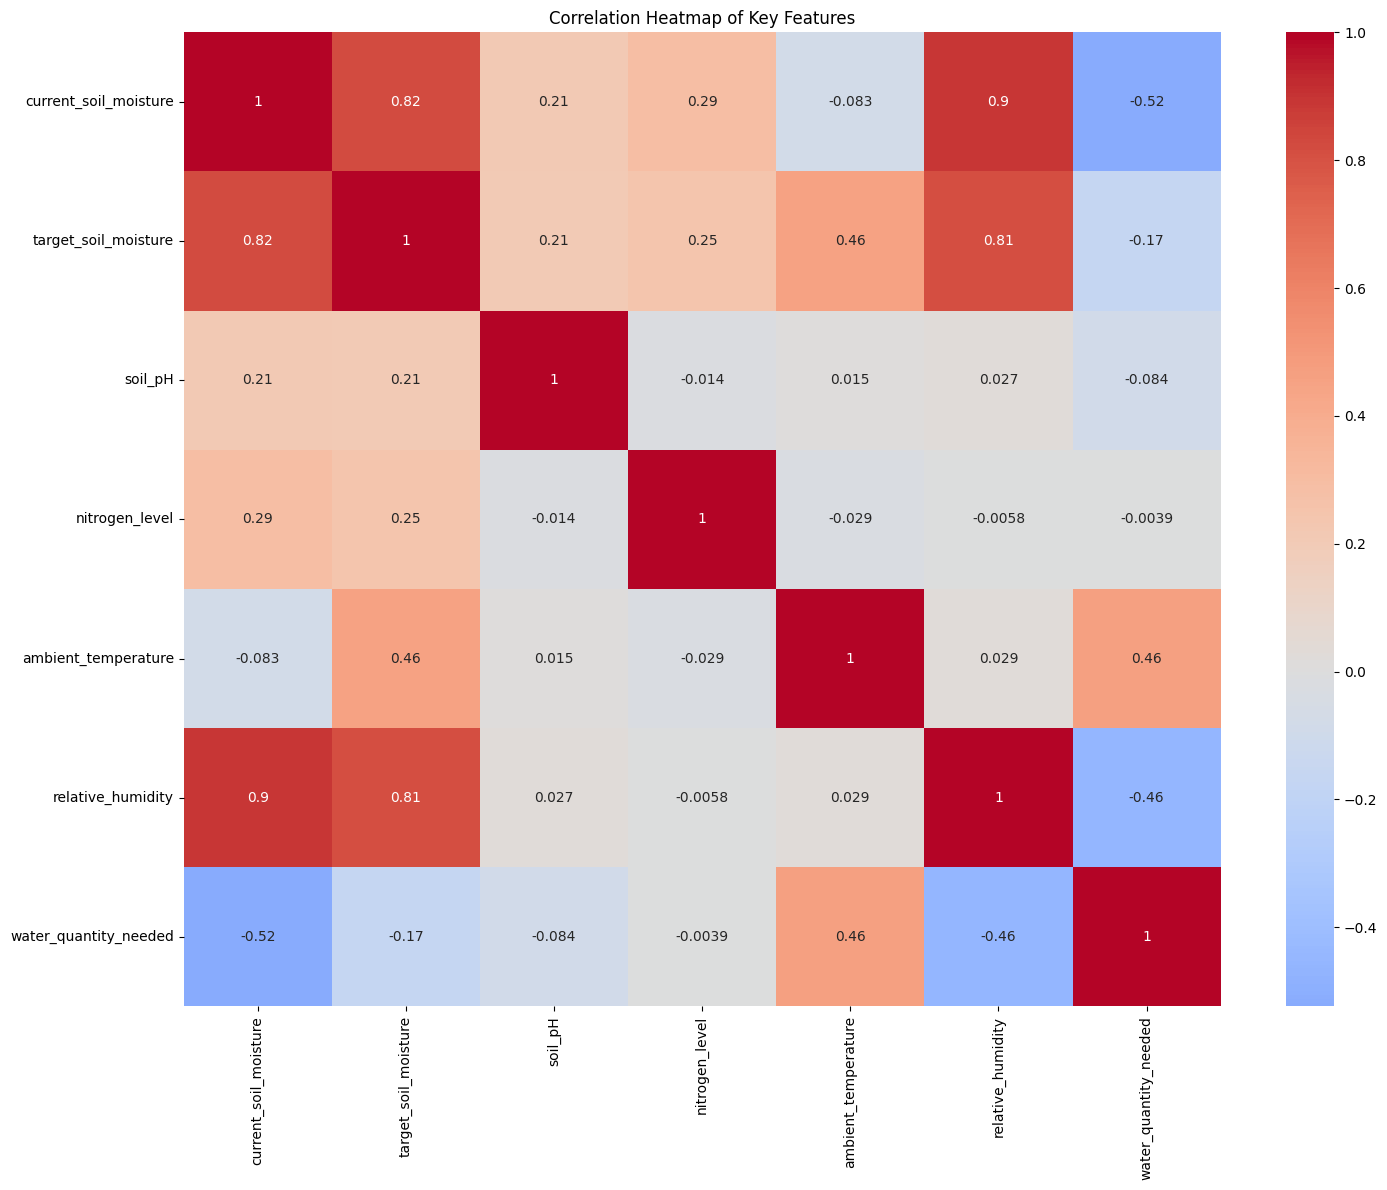

In [7]:
# Visualize correlations
plt.figure(figsize=(15, 12))
numerical_cols = ['current_soil_moisture', 'target_soil_moisture', 'soil_pH',
                 'nitrogen_level', 'ambient_temperature', 'relative_humidity',
                 'water_quantity_needed']
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Key Features')
plt.tight_layout()
plt.show()

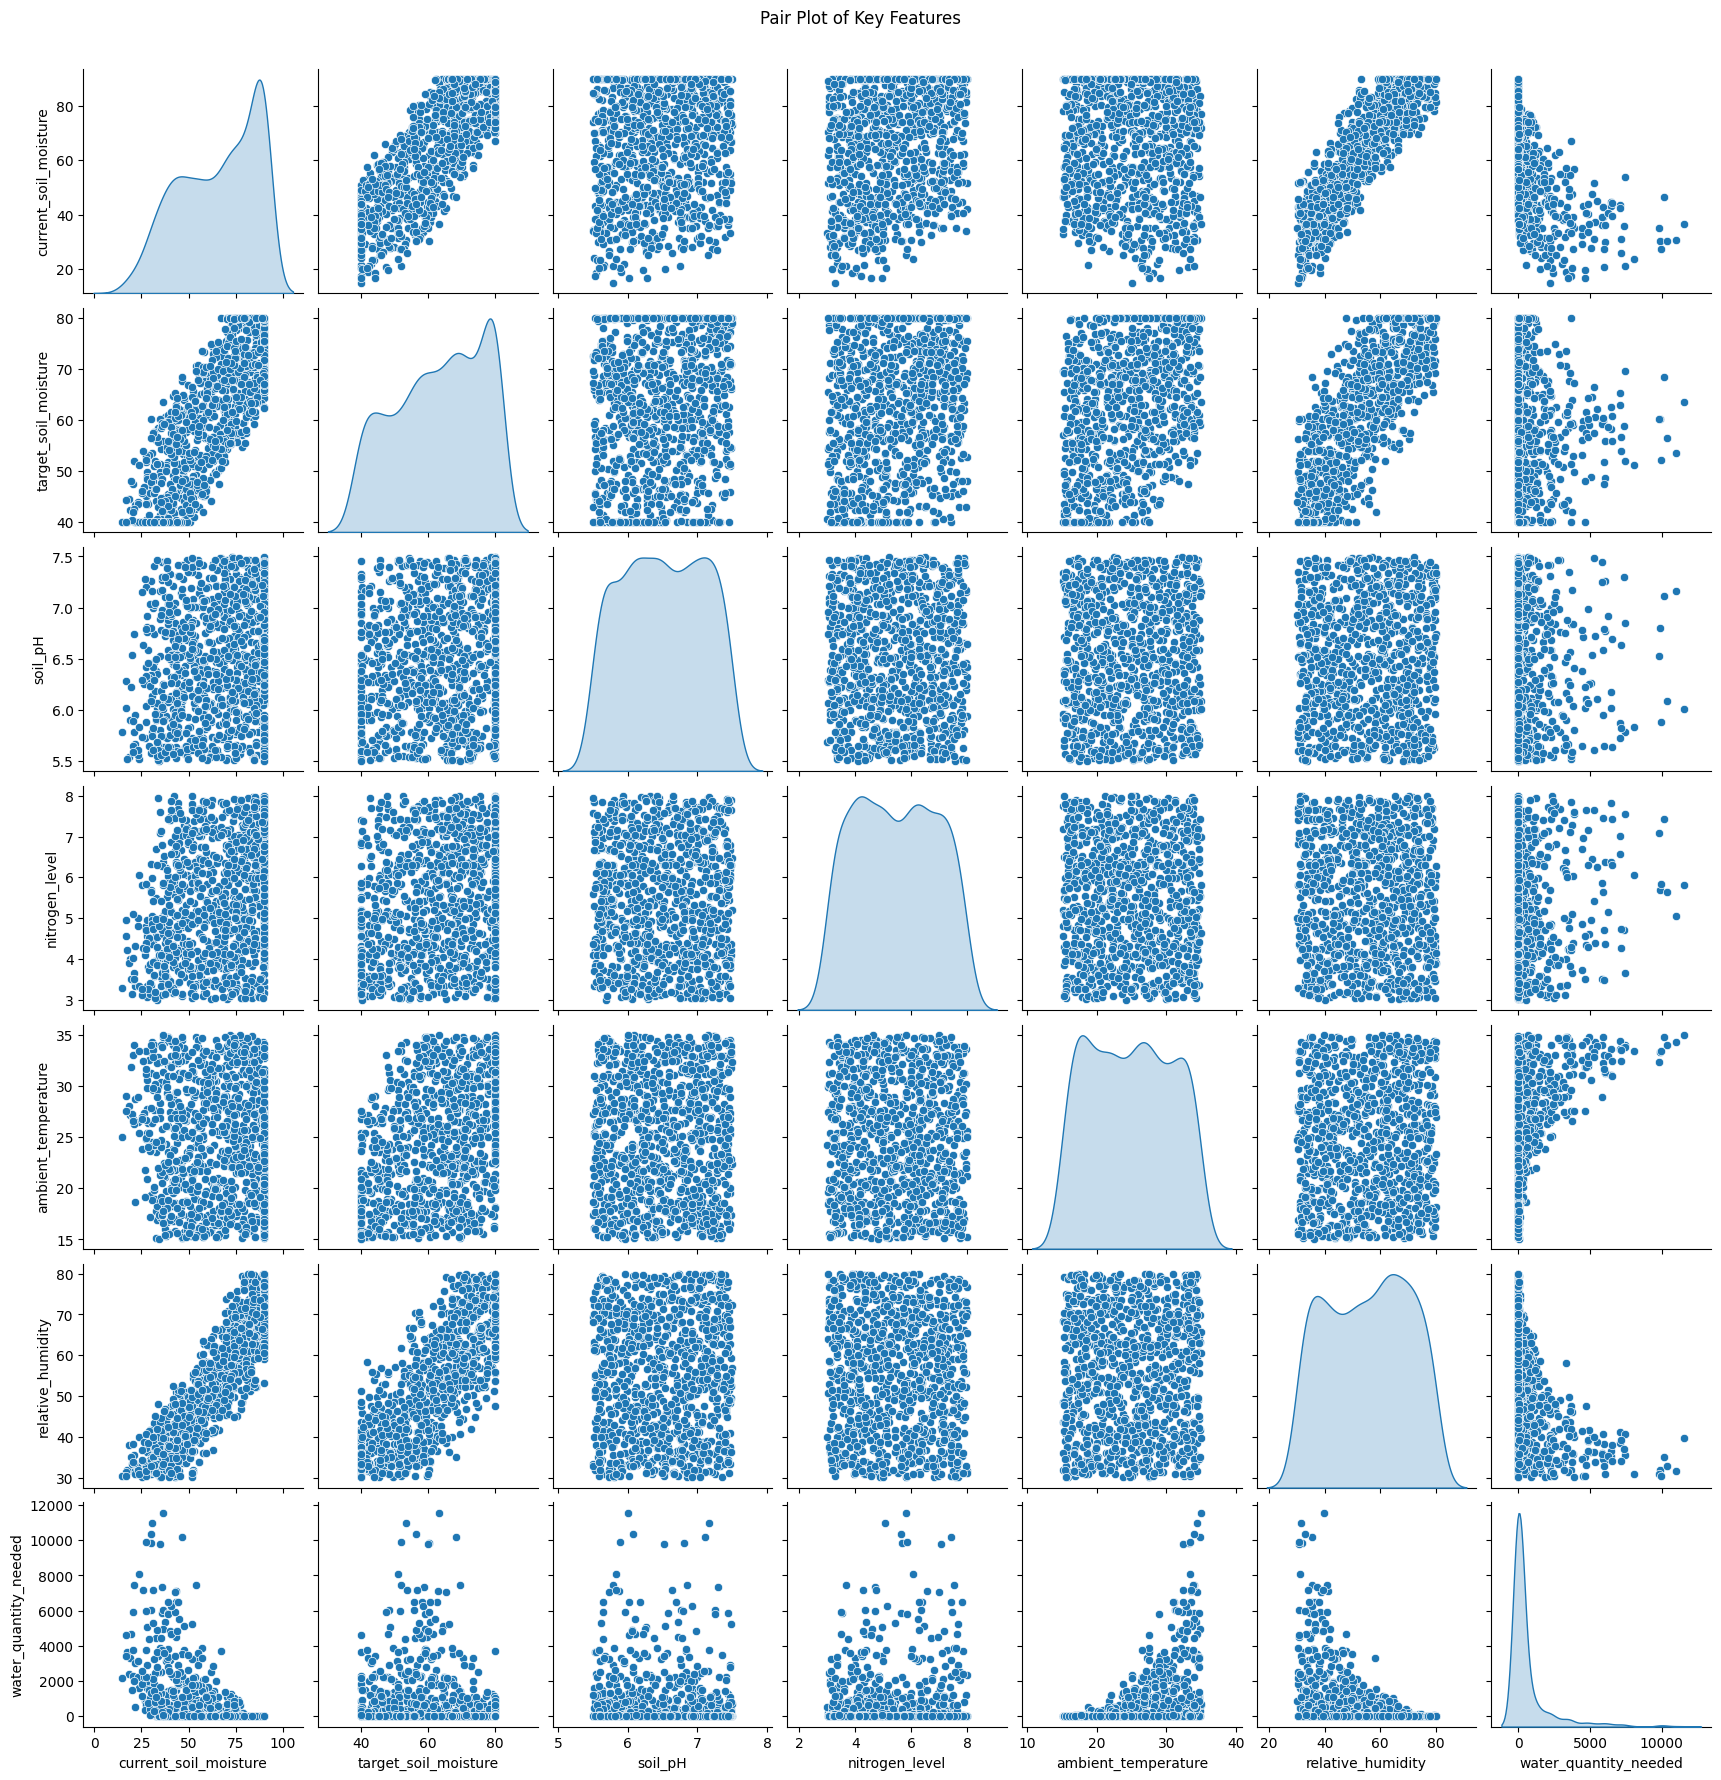

In [8]:
# Create pair plots for key features
sns.pairplot(df[numerical_cols], diag_kind='kde')
plt.suptitle('Pair Plot of Key Features', y=1.02)
plt.show()


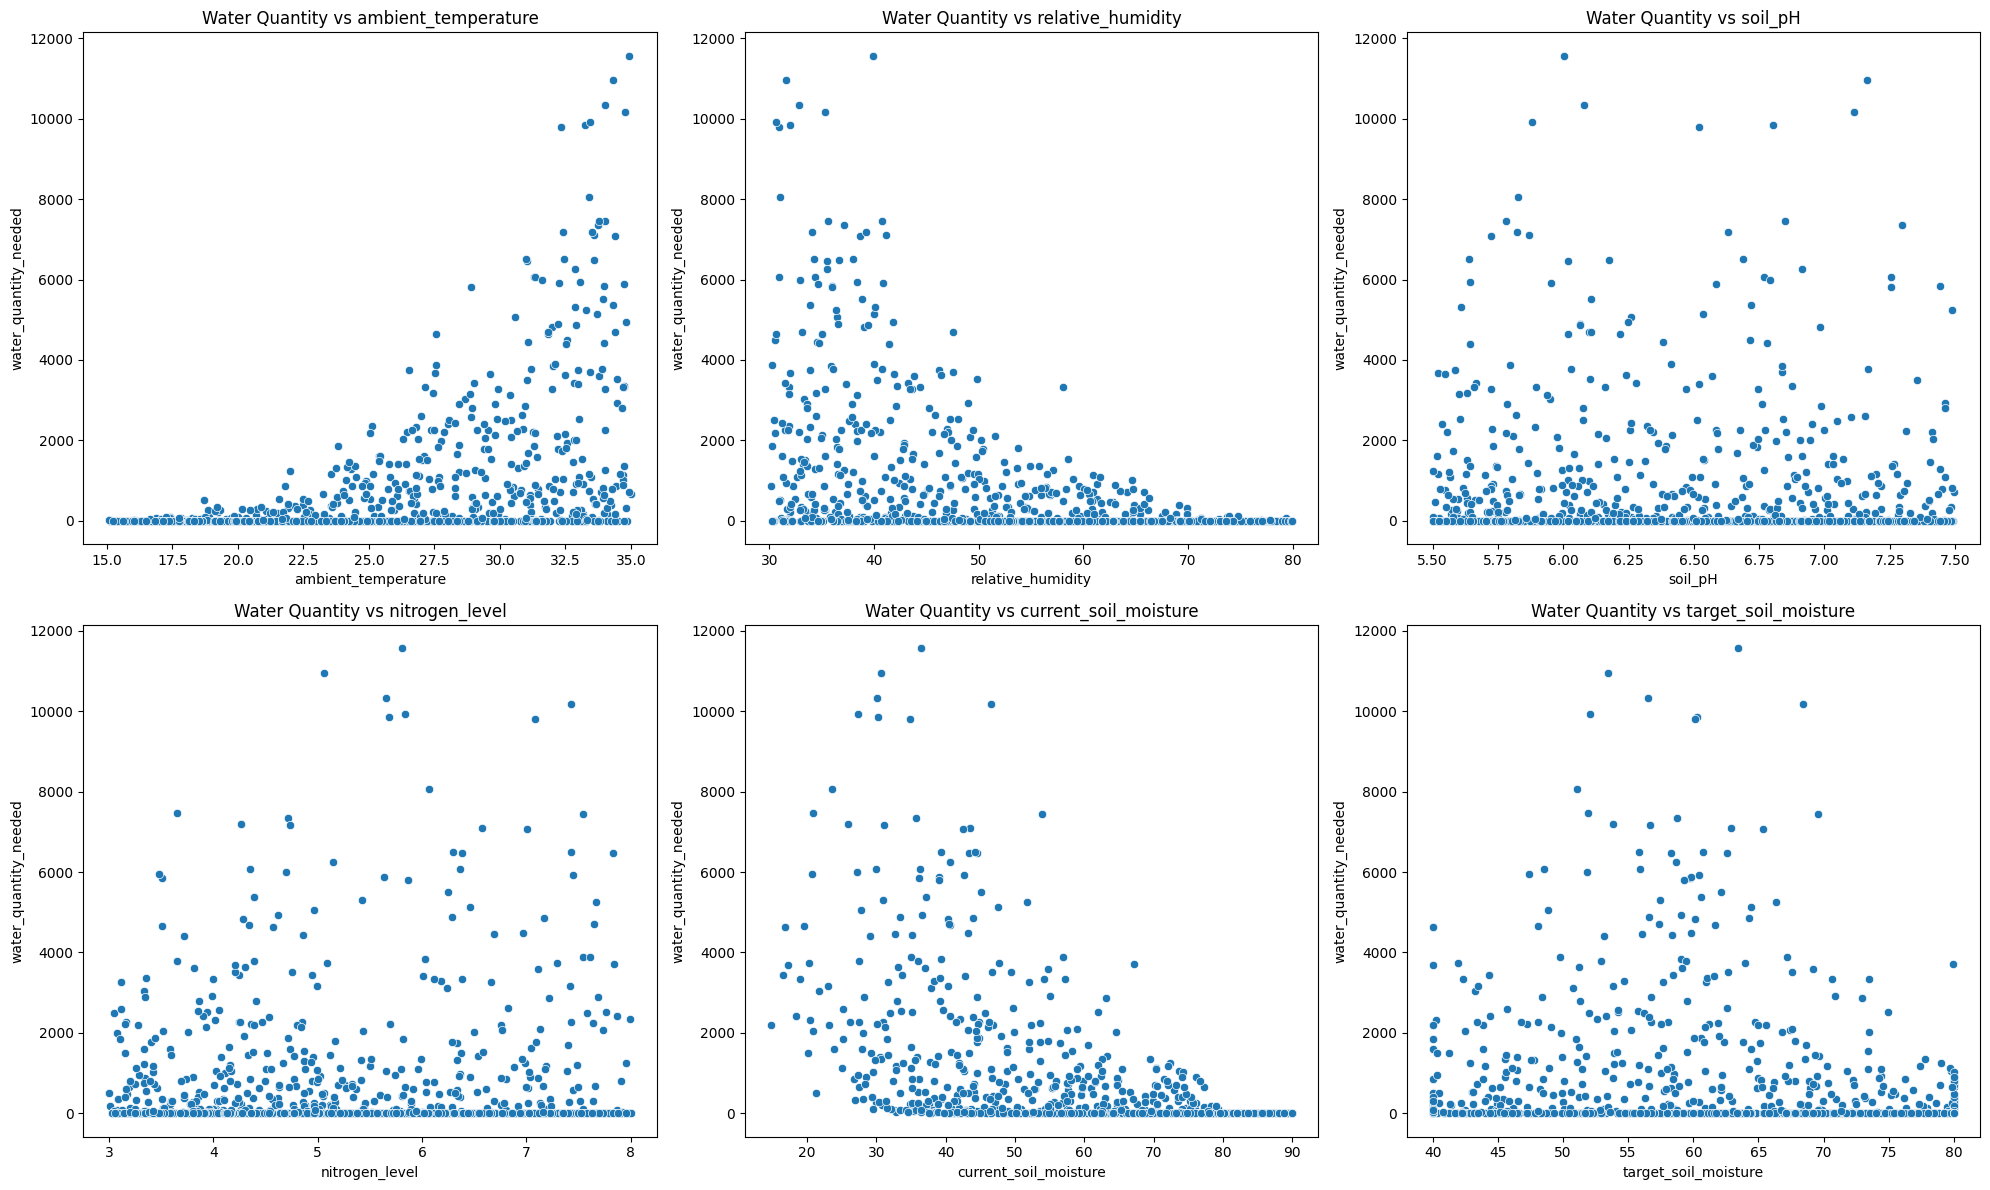

In [9]:
# Create individual relationship plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

features_to_plot = [
    'ambient_temperature', 'relative_humidity', 'soil_pH',
    'nitrogen_level', 'current_soil_moisture', 'target_soil_moisture'
]

for idx, feature in enumerate(features_to_plot):
    sns.scatterplot(data=df, x=feature, y='water_quantity_needed', ax=axes[idx])
    axes[idx].set_title(f'Water Quantity vs {feature}')

plt.tight_layout()
plt.show()


<ipython-input-10-dcfca4fb431c>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
<ipython-input-10-dcfca4fb431c>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
<ipython-input-10-dcfca4fb431c>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
<ipython-input-10-dcfca4fb431c>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)


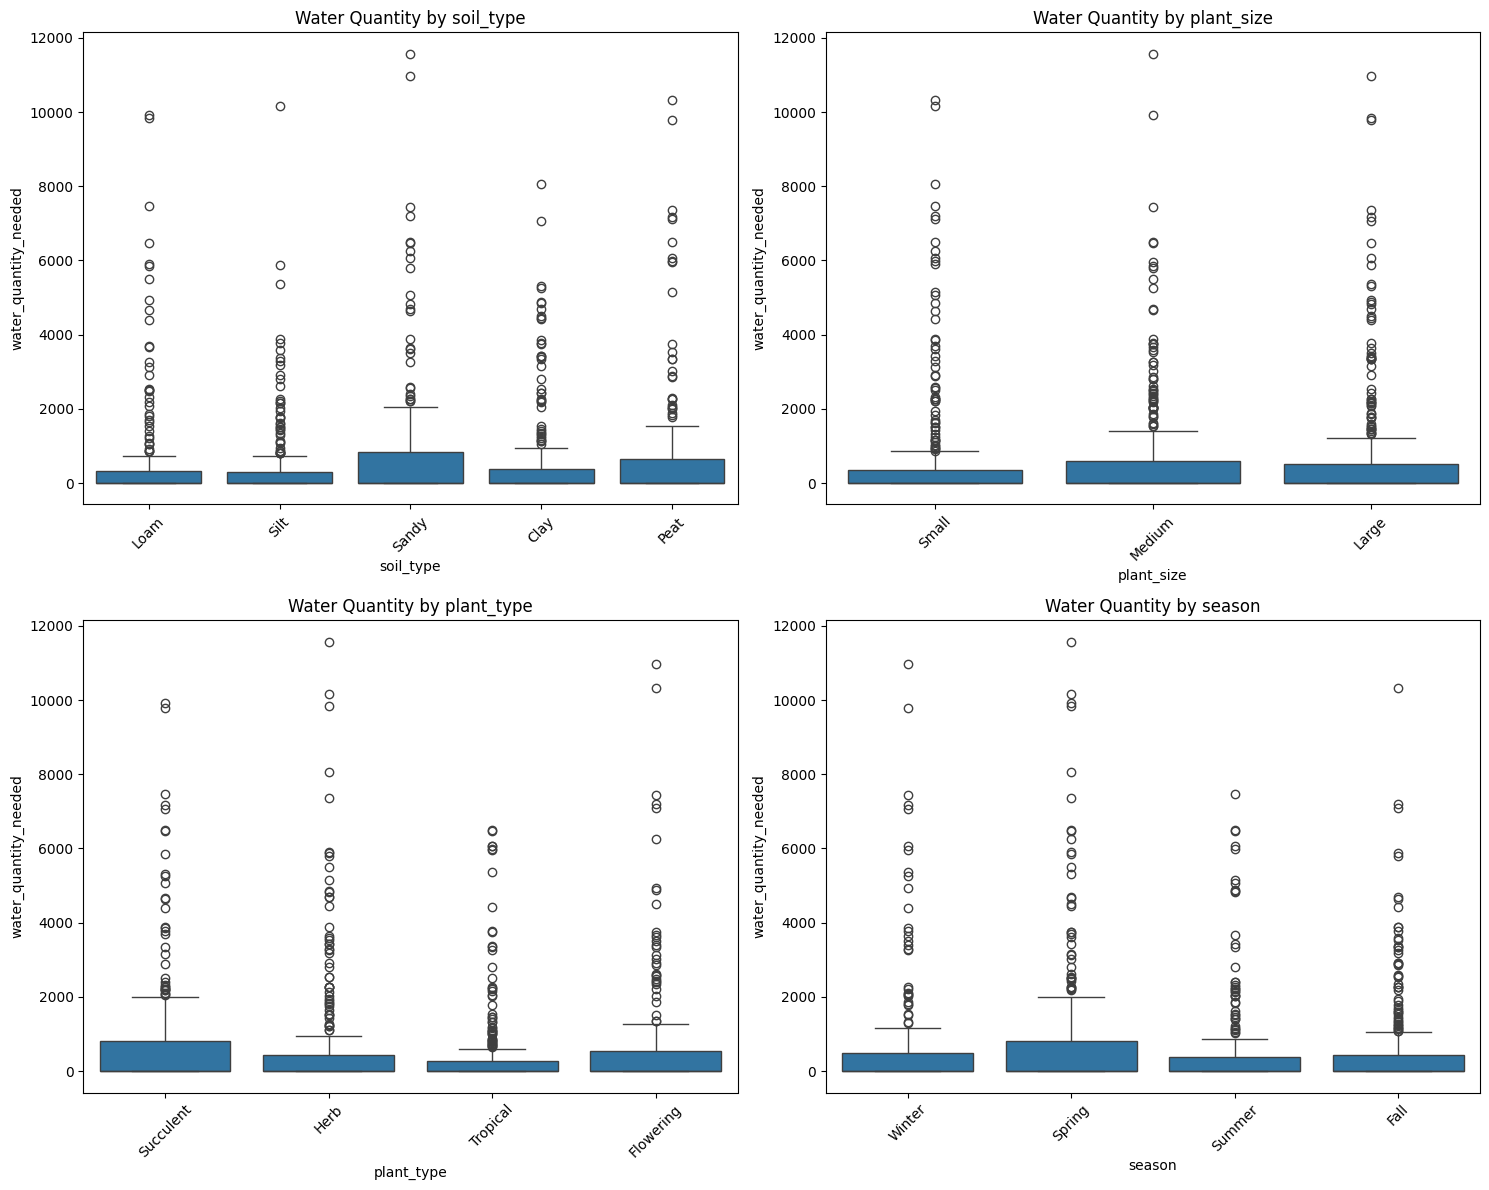

In [10]:
# Box plots for categorical variables
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

categorical_features = ['soil_type', 'plant_size', 'plant_type', 'season']
for idx, feature in enumerate(categorical_features):
    sns.boxplot(data=df, x=feature, y='water_quantity_needed', ax=axes[idx])
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
    axes[idx].set_title(f'Water Quantity by {feature}')

plt.tight_layout()
plt.show()


In [11]:
# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features) # Changed sparse to sparse_output
    ])

# Create pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['current_soil_moisture',
                                                   'target_soil_moisture',
                                                   'soil_depth_in_pot',
                                                   'soil_compaction_level',
                                                   'soil_pH', 'nitrogen_level',
                                                   'ambient_temperature',
                                                   'relative_humidity',
                                                   'sunlight_exposure',
                                                   'leaf_surface_area',
                                                   'number_of_leaves',
                                                   'time_since_last_watering',
                                                   'time_of_day']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['soil_type', 'plant_size',
                                                   'plant_type', 'season'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

Training R² score: 0.9816
Testing R² score: 0.8490


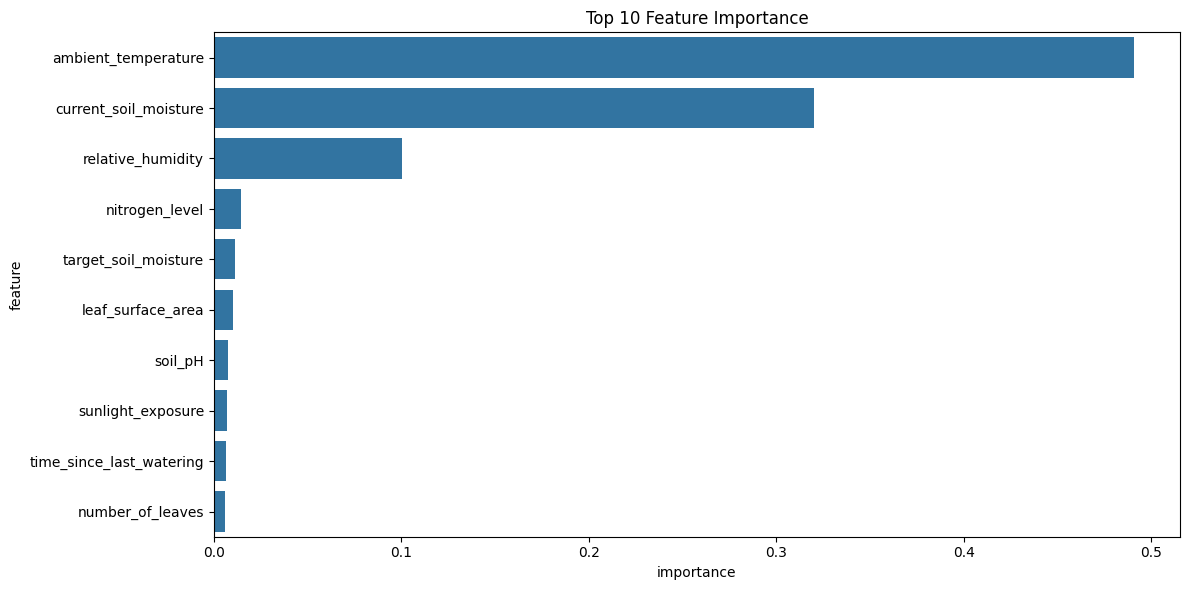

In [12]:
# Print model performance
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Training R² score: {train_score:.4f}")
print(f"Testing R² score: {test_score:.4f}")

# Feature importance plot
feature_importance = model.named_steps['regressor'].feature_importances_
feature_names = (numerical_features +
                [f"{feat}_{val}" for feat, vals in
                 zip(categorical_features,
                     preprocessor.named_transformers_['cat'].categories_)
                 for val in vals[1:]])

plt.figure(figsize=(12, 6))
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance_df.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

In [13]:
# Sort and display feature importance
feature_importance_dict = dict(zip(feature_names, feature_importance))
sorted_feature_importance = dict(sorted(feature_importance_dict.items(),
                                      key=lambda x: x[1],
                                      reverse=True))

print("\nTop 10 Most Important Features:")
for feat, imp in list(sorted_feature_importance.items())[:10]:
    print(f"{feat}: {imp:.4f}")


Top 10 Most Important Features:
ambient_temperature: 0.4909
current_soil_moisture: 0.3203
relative_humidity: 0.1005
nitrogen_level: 0.0145
target_soil_moisture: 0.0113
leaf_surface_area: 0.0102
soil_pH: 0.0075
sunlight_exposure: 0.0072
time_since_last_watering: 0.0066
number_of_leaves: 0.0058


In [14]:
import pickle

# Save the model
with open('water_prediction_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# To load the model later
with open('water_prediction_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [15]:
# prompt: Name all the features that have high importance, top 10

import pandas as pd
# Get feature importances
feature_importance = model.named_steps['regressor'].feature_importances_
feature_names = (numerical_features +
                [f"{feat}_{val}" for feat, vals in
                 zip(categorical_features,
                     preprocessor.named_transformers_['cat'].categories_)
                 for val in vals[1:]])

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Print or display the top 10 features
print("Top 10 most important features:")
print(feature_importance_df.head(10))


Top 10 most important features:
                     feature  importance
6        ambient_temperature    0.490929
0      current_soil_moisture    0.320293
7          relative_humidity    0.100544
5             nitrogen_level    0.014471
1       target_soil_moisture    0.011281
9          leaf_surface_area    0.010181
4                    soil_pH    0.007521
8          sunlight_exposure    0.007176
11  time_since_last_watering    0.006637
10          number_of_leaves    0.005751


In [17]:
import pickle
import pandas as pd
import numpy as np

# Load the saved model
with open('water_prediction_model.pkl', 'rb') as file:
    model = pickle.load(file)

def predict_water_quantity(data):
    """
    Make predictions using the loaded model

    Parameters:
    data (dict or pd.DataFrame): Input data with required features

    Returns:
    float: Predicted water quantity in ml
    """
    if isinstance(data, dict):
        data = pd.DataFrame([data])
    return model.predict(data)[0]

# Test Case 1: Hot, dry summer day
test_case_1 = {
    'current_soil_moisture': 30.0,  # Low moisture
    'target_soil_moisture': 65.0,
    'soil_type': 'Sandy',
    'soil_depth_in_pot': 20.0,
    'soil_compaction_level': 3,
    'soil_pH': 6.5,
    'nitrogen_level': 5.0,
    'ambient_temperature': 32.0,  # Hot
    'relative_humidity': 40.0,    # Dry
    'sunlight_exposure': 8.0,
    'plant_size': 'Medium',
    'leaf_surface_area': 200.0,
    'plant_type': 'Tropical',
    'number_of_leaves': 20,
    'time_since_last_watering': 48.0,
    'time_of_day': 14,
    'season': 'Summer'
}

# Test Case 2: Cool, humid winter day
test_case_2 = {
    'current_soil_moisture': 55.0,  # Moderate moisture
    'target_soil_moisture': 60.0,
    'soil_type': 'Clay',
    'soil_depth_in_pot': 15.0,
    'soil_compaction_level': 4,
    'soil_pH': 7.0,
    'nitrogen_level': 4.0,
    'ambient_temperature': 18.0,  # Cool
    'relative_humidity': 70.0,    # Humid
    'sunlight_exposure': 4.0,
    'plant_size': 'Small',
    'leaf_surface_area': 100.0,
    'plant_type': 'Succulent',
    'number_of_leaves': 10,
    'time_since_last_watering': 72.0,
    'time_of_day': 10,
    'season': 'Winter'
}

# Test Case 3: Moderate spring day
test_case_3 = {
    'current_soil_moisture': 45.0,  # Moderate moisture
    'target_soil_moisture': 60.0,
    'soil_type': 'Loam',
    'soil_depth_in_pot': 25.0,
    'soil_compaction_level': 2,
    'soil_pH': 6.0,
    'nitrogen_level': 6.0,
    'ambient_temperature': 24.0,  # Moderate
    'relative_humidity': 55.0,    # Moderate
    'sunlight_exposure': 6.0,
    'plant_size': 'Large',
    'leaf_surface_area': 300.0,
    'plant_type': 'Herb',
    'number_of_leaves': 30,
    'time_since_last_watering': 24.0,
    'time_of_day': 12,
    'season': 'Spring'
}

# Test Case 4: Critical low moisture
test_case_4 = {
    'current_soil_moisture': 15.0,  # Very low moisture
    'target_soil_moisture': 70.0,
    'soil_type': 'Peat',
    'soil_depth_in_pot': 18.0,
    'soil_compaction_level': 2,
    'soil_pH': 5.5,
    'nitrogen_level': 7.0,
    'ambient_temperature': 28.0,
    'relative_humidity': 45.0,
    'sunlight_exposure': 7.0,
    'plant_size': 'Large',
    'leaf_surface_area': 400.0,
    'plant_type': 'Tropical',
    'number_of_leaves': 25,
    'time_since_last_watering': 96.0,
    'time_of_day': 16,
    'season': 'Summer'
}

# Create a function to explain the prediction
def explain_prediction(test_case, prediction):
    moisture_diff = test_case['target_soil_moisture'] - test_case['current_soil_moisture']

    explanation = f"""
    Prediction Analysis:
    -------------------
    Predicted water quantity: {prediction:.2f} ml

    Key Factors:
    - Moisture difference: {moisture_diff:.1f}% (Current: {test_case['current_soil_moisture']}%, Target: {test_case['target_soil_moisture']}%)
    - Temperature: {test_case['ambient_temperature']}°C
    - Humidity: {test_case['relative_humidity']}%
    - Soil type: {test_case['soil_type']}
    - Plant type: {test_case['plant_type']}
    - Time since last watering: {test_case['time_since_last_watering']} hours
    - Season: {test_case['season']}
    """
    return explanation

# Test all cases
test_cases = {
    "Hot Summer Day": test_case_1,
    "Cool Winter Day": test_case_2,
    "Moderate Spring Day": test_case_3,
    "Critical Low Moisture": test_case_4
}

print("Model Testing Results:")
print("=====================")

for case_name, test_case in test_cases.items():
    prediction = predict_water_quantity(test_case)
    print(f"\nTest Case: {case_name}")
    print(explain_prediction(test_case, prediction))

# Function to test custom input
def test_custom_input():
    print("\nCustom Input Test")
    print("=================")

    # Get user input for key parameters
    try:
        current_moisture = float(input("Enter current soil moisture (%): "))
        target_moisture = float(input("Enter target soil moisture (%): "))
        temperature = float(input("Enter temperature (°C): "))
        humidity = float(input("Enter humidity (%): "))
        soil_type = input("Enter soil type (Clay/Loam/Sandy/Silt/Peat): ")
        plant_type = input("Enter plant type (Succulent/Tropical/Herb/Flowering): ")

        # Create test case with default values for other parameters
        custom_case = {
            'current_soil_moisture': current_moisture,
            'target_soil_moisture': target_moisture,
            'soil_type': soil_type,
            'soil_depth_in_pot': 20.0,
            'soil_compaction_level': 3,
            'soil_pH': 6.5,
            'nitrogen_level': 5.0,
            'ambient_temperature': temperature,
            'relative_humidity': humidity,
            'sunlight_exposure': 6.0,
            'plant_size': 'Medium',
            'leaf_surface_area': 200.0,
            'plant_type': plant_type,
            'number_of_leaves': 20,
            'time_since_last_watering': 24.0,
            'time_of_day': 12,
            'season': 'Summer'
        }

        prediction = predict_water_quantity(custom_case)
        print(explain_prediction(custom_case, prediction))

    except ValueError:
        print("Invalid input. Please enter numeric values for measurements.")
    except Exception as e:
        print(f"Error: {str(e)}")

# Allow user to test custom input
while True:
    response = input("\nWould you like to test a custom input? (yes/no): ")
    if response.lower() == 'yes':
        test_custom_input()
    else:
        break

print("\nTesting completed!")

Model Testing Results:

Test Case: Hot Summer Day

    Prediction Analysis:
    -------------------
    Predicted water quantity: 5715.08 ml
    
    Key Factors:
    - Moisture difference: 35.0% (Current: 30.0%, Target: 65.0%)
    - Temperature: 32.0°C
    - Humidity: 40.0%
    - Soil type: Sandy
    - Plant type: Tropical
    - Time since last watering: 48.0 hours
    - Season: Summer
    

Test Case: Cool Winter Day

    Prediction Analysis:
    -------------------
    Predicted water quantity: 122.59 ml
    
    Key Factors:
    - Moisture difference: 5.0% (Current: 55.0%, Target: 60.0%)
    - Temperature: 18.0°C
    - Humidity: 70.0%
    - Soil type: Clay
    - Plant type: Succulent
    - Time since last watering: 72.0 hours
    - Season: Winter
    

Test Case: Moderate Spring Day

    Prediction Analysis:
    -------------------
    Predicted water quantity: 602.88 ml
    
    Key Factors:
    - Moisture difference: 15.0% (Current: 45.0%, Target: 60.0%)
    - Temperature: 24.0°C

KeyboardInterrupt: Interrupted by user

Code Finished